# Chemical Structure Alignment

Molecular alignment is a fundamental problem in cheminformatics and can be usedfor  structure  determination,  similarity  based  searching,  and  ligand-baseddrug design et al. This problem can be solved by orthogonal Procrustes when given two matrices representing three-dimensional coordinates.  The code block below showsthe ease-of-use of the `Procrustes` library for protein structure alignment, one of themost fundamental problems in structural biophysics.

Here, we are going to use `procrustes.rotational` for protein structure alignment as an example, which is one of the fundamental problems in structural biology and structured-based drug design. A well-known structure alignment method is the *Kabsch* algorithm, which involves three steps: 
1. translation of the structures to have a common centroid;
2. computation of the coordinate covariance matrix;
3. finding the optimal rotation matrix. 

This is simply a rotational Procrustes problem.

The human deoyhemoglobin X-ray crystal structure is used here (PDB ID: 2HHB), which allows comparison to the  BiomolecularStructures package (https://github.com/hng/BiomolecularStructures.jl). 
The structure has cyclic-C2 global symmetry, where chain A (red)
and chain C (blue) are hemoglobin (deoxy) alpha chains, and chain B and D are hemoglobin deoxy beta chains (grey) (**Fig (i)**).  The rotational-orthogonal Procrustes will be used to align the Cα atoms in different chains of the protein.

![Fig. 1. protein structure alignment with rotational Procrustes.](notebook_data/chemical_strcuture_alignment/protein_alignment.png "Fig. 1. protein structure alignment with rotational Procrustes.")

In [ ]:
# install iodata
!pip install git+https://github.com/theochem/iodata.git@master

# install matplotlib
!pip install matplotlib

We will load $C_{\alpha}$ atom coordinates with `iodata` (https://github.com/theochem/iodata).

In [1]:
import numpy as np
    
from iodata import load_one
from iodata.utils import angstrom
from procrustes import rotational

# load PDB
pdb = load_one("notebook_data/chemical_strcuture_alignment/2hhb.pdb")

# get coordinates of C_alpha atoms in chains A & C (in angstrom)
chainid = pdb.extra['chainids']
attypes = pdb.atffparams['attypes']
# alpha carbon atom coordinates in chain A
ca_a = pdb.atcoords[(chainid == 'A') & (attypes == 'CA')] / angstrom
# alpha carbon atom coordinates in chain A
ca_c = pdb.atcoords[(chainid == 'C') & (attypes == 'CA')] / angstrom

Root-mean-square deviation (RMSD) is a used to assess the 
discrepancy between structures, and was calculated before and after superposition translation and rotation operations were performed by rotational orthogonal Procrustes. The RMSD values before alignment is calculated as 39.47 Å, reaffirming that chain A and chain C are far
away from each other. 

In [2]:
rmsd_before = np.sqrt(np.mean(np.sum((ca_a - ca_c)**2, axis=1)))
print("RMSD of initial coordinates:", rmsd_before)

RMSD of initial coordinates: 39.46851987559469


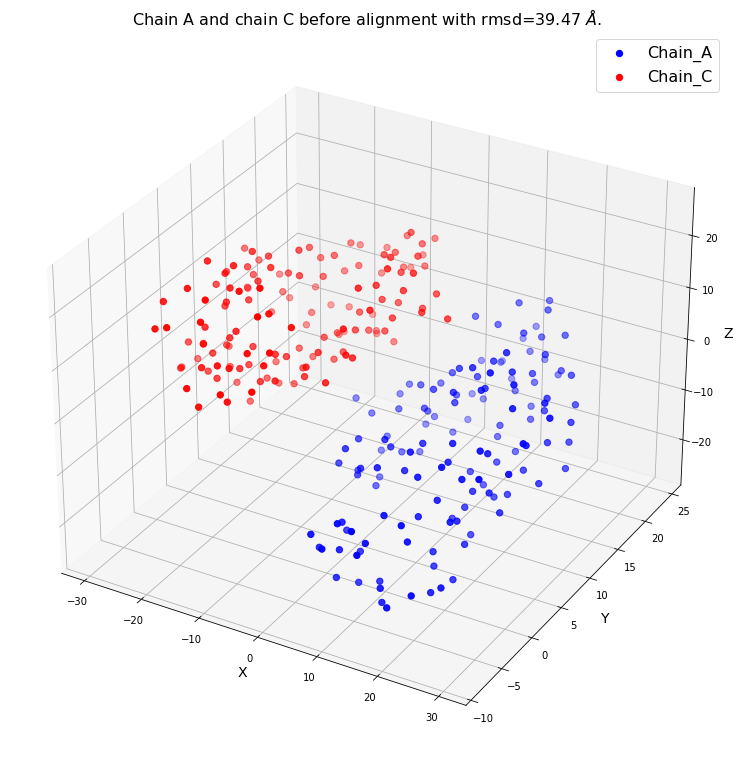

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# plot the coordinates before alignment which reproduces Fig. (ii)
fig = plt.figure(figsize=(12, 10))
ax = Axes3D(fig)

ax.scatter(xs=ca_a[:, 0], ys=ca_a[:, 1], zs=ca_a[:, 2], 
           marker="o", color="blue", s=40, label="Chain_A")
ax.scatter(xs=ca_c[:, 0], ys=ca_c[:, 1], zs=ca_c[:, 2], 
           marker="o", color="red", s=40, label="Chain_C")

ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
ax.legend(fontsize=16, loc='best')

plt.title("Chain A and chain C before alignment with rmsd={:0.2f} $\AA$.".format(rmsd_before),
          fontsize=16)
plt.show()

# if you want to save the figure, uncomment next line
# plt.savefig('before_align.png', dpi=300)

Now, we use rotational Procrustes to perform the structure alignment.

In [4]:
result = rotational(ca_a, ca_c, translate=True)

In [5]:
# compute transformed (translated & rotated) coordinates of chain A
ca_at = np.dot(result.new_a, result.t)

In [6]:
# now new_A is the array after rotation
rmsd_after = np.sqrt(np.mean(np.sum((ca_at - result.new_b)**2, axis=1)))
print("RMSD of transformed coordinates:", rmsd_after)

RMSD of transformed coordinates: 0.23003870483785005


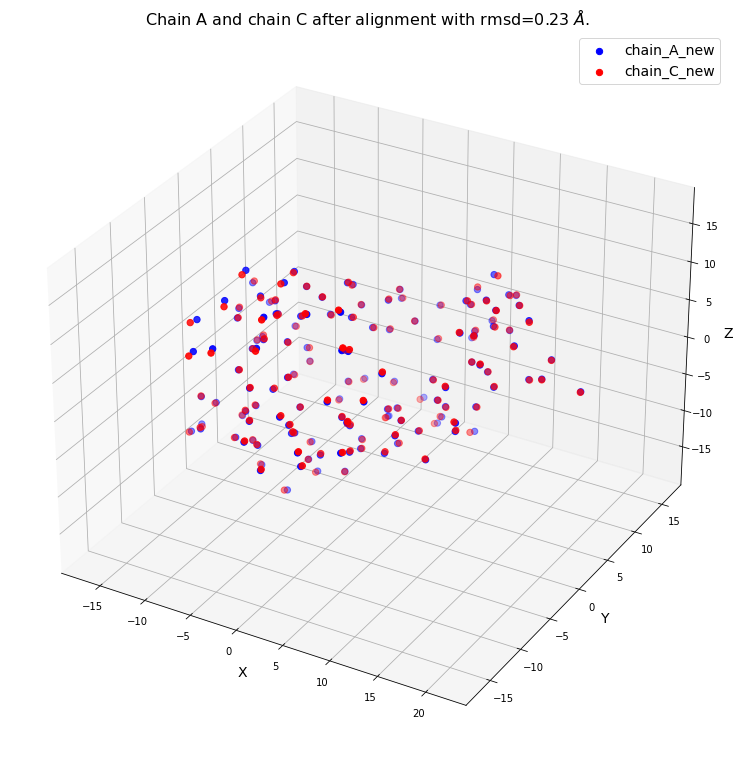

In [7]:
# plot the coordinates after alignment which reproduces Fig. (ii)
fig = plt.figure(figsize=(12, 10))
ax = Axes3D(fig)
# ax = fig.add_subplot(111, projection='3d')

ax.scatter(ca_at[:,0], ca_at[:,1], ca_at[:,2], 
           zdir='z', s=40, c='blue', label='chain_A_new')
ax.scatter(result["new_b"][:,0], result["new_b"][:,1], result["new_b"][:,2], 
           zdir='z', s=40, c='red', label='chain_C_new')

ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
ax.legend(fontsize=14, loc='best')

plt.title("Chain A and chain C after alignment with rmsd={:0.2f} $\AA$.".format(rmsd_after),
          fontsize=16)
plt.show()
# if you want to save the figure, uncomment next line
# plt.savefig('after_align.png', dpi=300)

All the Cα atoms become close to each other after to
translation and rotation (the above figure) with rmsd value 0.23 $\unicode{x212B}$. This affirms that the utility of rotationalorthogonal Procrustes in protein alignment.